# Visualizing gpx data

## Imports

In [1]:
from math import sqrt, floor

import datetime
from math import sqrt, floor
import numpy as np
import pandas as pd
import haversine


# https://github.com/christopherbronner/gps-run-tracker/blob/master/GPS%20tracker.ipynb
import gpxpy
import gpxpy.gpx
from time import strftime
import matplotlib.pyplot as plt
import copy
from matplotlib.cm import terrain # import color map
from matplotlib.cm import cool # import color map
import ipyleaflet as lf

from geopy import distance as gpyd
from geographiclib.geodesic import Geodesic #for heading
geod = Geodesic.WGS84  # define the WGS84 ellipsoid
# from GPX_reader import GPX_interpolate as gpx_interpolate #for interpolating
import gpx_interpolate

from math import degrees, cos, sin, atan2 #for bearing calculations
from scipy.signal import find_peaks #for hairpin detection

import statistics #for standard deviation of turns
import os #to get files

from scipy.signal import savgol_filter
import seaborn as sns # seaborn for plotting

### Pull in the gps data

In [2]:
def gpxfile_to_lat_lon(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)

    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele, gpx
#     files.append(filename)
#         courses.append(os.path.splitext(base)[0])

In [3]:
def gpxfile_to_gpx(path, filename):
    base=os.path.basename(path + filename)
    gpx_file = open(path + filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    
    return gpx

In [4]:
def gpx_to_lat_lon(gpx):
    lat = []
    lon = []
    ele = []
    tstamp = []
    tzinfo = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
#                 df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
#                 df = df.append(df_newRow, ignore_index=True)
                ele.append(point.elevation)
    return lat, lon, ele

In [5]:
# path, filename = ('/Users/jeremywalsh/OneDrive - SUEZ/Personal/XC/Race GPX/Courses/',
#  'Bayfront Park 7km.gpx')
# lat, lon = gpx_to_lat_lon(path, filename)

### Plot the gps course

In [6]:
# #fig = plt.figure(facecolor = '0.05')
# fig = plt.figure()
# ax = plt.Axes(fig, [0., 0., 1., 1.], )
# #ax.set_aspect('equal')
# ax.set_axis_off()
# fig.add_axes(ax)
# plt.plot(lon, lat, color = 'deepskyblue', lw = 0.2, alpha = 0.8)
# plt.show()

### Interpolate to get more data points

In [7]:
# res = 1 #one point every meter
# deg = 2

# gpx_data = {'lat':lat,
#             'lon':lon,
#             'ele':elev,
#             'tstamp':None,
#             'tzinfo':None}

# gpx_data_interp = gpx_interpolate(gpx_data, res, deg)

In [8]:
# def gpx_interpolate(lat, lon, filename):
#     res = 1 #one point every meter
#     deg = 2

#     gpx_data = {'lat':lat,
#                 'lon':lon,
#                 'ele':elev,
#                 'tstamp':None,
#                 'tzinfo':None}

#     gpx_data_interp = gpx_interpolate(gpx_data, res, deg)

#     fig = plt.figure(figsize=(40,20))
#     plt.scatter(gpx_data_interp['lon'], gpx_data_interp['lat'], s=1)
#     plt.scatter(lon, lat)
#     plt.show()
#     fig.savefig(filename)
    
#     return gpx_interpolate

In [9]:
# gpx_interpolate(lat, lon, filename)

## Get the heading

In [10]:
# Geodesic.WGS84.Inverse(-41.32, 174.81, 40.96, -5.50)
# df[['lon', 'lat']].iloc[0][0]


def angle_diff(gpx_data_interp, window):
    bearing = []
    p2p_distance = []

    for i in range(len(gpx_data_interp['lon'])-1):
        lon1 = gpx_data_interp['lon'][i]
        lat1 = gpx_data_interp['lat'][i]
        lon2 = gpx_data_interp['lon'][i+1]
        lat2 = gpx_data_interp['lat'][i+1]

        bearing_tmp = atan2(sin(lon2-lon1)*cos(lat2), cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1))
        bearing_tmp = degrees(bearing_tmp)
        bearing_tmp = (bearing_tmp + 360) % 360
        bearing.append(bearing_tmp)

    #     bearing.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['azi1']) #degrees clockwise from north)
        p2p_distance.append(Geodesic.WGS84.Inverse(lon1, lat1, lon2, lat2)['s12']) #distance between each point in meters
    
    #smoothing the bearing since for some tracks it is messy and throws off hairpin detection
#     bearing = savgol_filter(bearing, 41, 2) # window size 51, polynomial order 2
    
    # bearing.insert(0, np.nan) #making the same length as df
    p2p_distance.insert(0, 0) #making the same length as df
    p2p_distance = np.cumsum(p2p_distance)


    bearing_diff = [bearing[i + 1] - bearing[i] for i in range(len(bearing)-1)]
    angle_diff = [(bearing_diff[i] + 180) % 360 - 180 for i in range(len(bearing)-1)]

    angle_df = pd.DataFrame(angle_diff).rolling(window=window, center=True).sum()
    angle_df = angle_df.abs() # taking the absolute value so we get all the peask

    angle_df.loc[-1] = [np.nan]
    angle_df.loc[-2] = [np.nan]

    angle_df.index = angle_df.index + 3  # shifting index
    angle_df.sort_index(inplace=True) 

    df = pd.DataFrame({'lat':gpx_data_interp['lat'],'lon':gpx_data_interp['lon'], 'angle_diff':angle_df[0]})
    return df, bearing

In [11]:
# window = 40 #meters long to consider a hairpin turn complete
# df, bearing = angle_diff(gpx_data_interp,window)

## Hairpin turn detection via bearing angle difference peak detection

In [12]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

In [13]:
def hairpin_detection(df, height, bearing, gpx_data_interp, course):
    peaks, _ = find_peaks(df['angle_diff'], height=height, prominence=50)
    print('Number of hairpins in course')
    print(len(peaks))
    
#     plot it
    fig = plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 22})
    plt.plot(df['angle_diff'])
    plt.plot(bearing)
    
    plt.scatter(peaks, df['angle_diff'].iloc[peaks])
    plt.title('Bearing and Bearing Changes - ' + str(course))
    plt.show()
    
#     #plot them on the course
#     fig = plt.figure(figsize=(10,10))
#     plt.rcParams.update({'font.size': 30})
#     plt.scatter(gpx_data_interp['lon'], gpx_data_interp['lat'], s=5)
#     plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=100)
#     plt.title('Course Map with Hairpins - ' + str(course))
#     plt.show()
    
    # bokeh
    # Create the figure: p
    p = figure(title='Course Map with Hairpins - ' + str(course), x_axis_label='lon', y_axis_label='lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(gpx_data_interp['lon'], gpx_data_interp['lat'], size = 0.5)
    p.circle(df['lon'].iloc[peaks], df['lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    
    print('Standard Deviation')
    st_dev = statistics.stdev(df['angle_diff'].dropna())
    print(st_dev)
    print('Total Degrees Turned')
    tot_deg_turned = sum([abs(ele) for ele in df['angle_diff'].dropna()])
    print(tot_deg_turned)
    
    return st_dev, tot_deg_turned, len(peaks)

In [14]:
def add_distance(gpx, df):
    alt_dif = [0]
    time_dif = [0]
    dist_vin = [0]
    dist_hav = [0]
    dist_vin_no_alt = [0]
    dist_hav_no_alt = [0]
    dist_dif_hav_2d = [0]
    dist_dif_vin_2d = [0]

    
    data = gpx.tracks[0].segments[0].points
    for index in range(len(data)):
        if index == 0:
            pass
        else:
            start = data[index-1]

            stop = data[index]

            distance_vin_2d = gpyd.geodesic((start.latitude, start.longitude), (stop.latitude, stop.longitude)).m
            dist_dif_vin_2d.append(distance_vin_2d)

            distance_hav_2d = haversine.haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000

            dist_dif_hav_2d.append(distance_hav_2d)

            dist_vin_no_alt.append(dist_vin_no_alt[-1] + distance_vin_2d)

            dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)

            alt_d = start.elevation - stop.elevation

            alt_dif.append(alt_d)

            distance_vin_3d = sqrt(distance_vin_2d**2 + (alt_d)**2)

            distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2)

            try:
                time_delta = (stop.time - start.time).total_seconds()
            except:
                #no time in data
                time_delta = 0

            time_dif.append(time_delta)

            dist_vin.append(dist_vin[-1] + distance_vin_3d)

            dist_hav.append(dist_hav[-1] + distance_hav_3d)

    df1 = pd.DataFrame()
    df1['dis_vin_2d'] = dist_vin_no_alt 
    df1['dist_hav_2d'] = dist_hav_no_alt
    df1['dis_vin_3d'] = dist_vin
    df1['dis_hav_3d'] = dist_hav
    df1['alt_dif'] = alt_dif
    df1['time_dif'] = time_dif
    df1['dis_dif_hav_2d'] = dist_dif_hav_2d
    df1['dis_dif_vin_2d'] = dist_dif_vin_2d

#     print('Vincenty 2D : ', dist_vin_no_alt[-1])
#     print('Haversine 2D : ', dist_hav_no_alt[-1])
    print('Vincenty 3D : ', dist_vin[-1])
#     print('Haversine 3D : ', dist_hav[-1])
    print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')
    
    df = pd.concat([df, df1], axis=1)
    
    return df

In [15]:
from scipy.signal import argrelextrema

def plot_ele_max_min(df):
    # Plot results
    fig = plt.figure(figsize=(20,8))
    plt.scatter(df['dis_hav_3d'], df['min'], c='r')
    plt.scatter(df['dis_hav_3d'], df['max'], c='g')
    plt.plot(df['dis_hav_3d'], df['Elevation'])
    plt.show()

In [16]:
# height = 140 #number of degrees in a hairpin turn over the window length
# hairpin_detection(df, height, bearing, gpx_data_interp)

## Calculate Course Area
Look at the total area the course covers as a comparison for how turny the course is. ie how good is the course/race director at minimizing turns (if that was a desired goal).

In [17]:
def course_area(geod, df):
    p = geod.Polygon()
    for pnt in range(len(df)):
        if pnt == 0:
            continue
        p.AddPoint(df['lat'][pnt], df['lon'][pnt])

    num, perim, area = p.Compute()
    print("Race Distance/area of the course are {:.3f} m / {:.1f} m^2".format(perim, area))
    return perim, area

In [18]:
def hills(df):
    n=20 # number of points to be checked before and after 
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df['Elevation'].values, np.less_equal, order=n)[0]]['Elevation']
    df['max'] = df.iloc[argrelextrema(df['Elevation'].values, np.greater_equal, order=n)[0]]['Elevation']

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()]) #index locations of the max's
    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()]) #index locations of the min's

    #min locs remove duplicates
    for i in range(len(min_locs)):
        if i == len(min_locs)-1: #skip the last one
            continue
        else:
            if min_locs[i] == min_locs[i+1]-1: #check if it is the same as the previous one
                df['min'][min_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])

    #max locs remove duplicates
    for i in range(len(max_locs)):
        if i == len(max_locs)-1: #skip the last one
            continue
        else:
            if max_locs[i] == max_locs[i+1]-1: #check if it is the same as the previous one
                df['max'][max_locs[i]] = np.nan #setting it to nan so we don't have duplicates

    max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(max_locs)): #loop through each max location
        if i == len(max_locs)-1: #skip the last one to avoid out of range error b/c zero index
            continue
        else:
            min_val = df['min'][min_locs[i]] #get this hill's min elevation
            max_val = df['max'][max_locs[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df['dis_hav_3d'][min_locs[i]] #get this hill's start point
            hill_end = df['dis_hav_3d'][max_locs[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
            
    plot_ele_max_min(df)
        
    return min_vals, max_vals, hill_climbs, hill_lengths, df

In [19]:
def hill_details(df, peaks, mins):
#     min_locs = df['min'].index.get_indexer(df['min'].index[~df['min'].isnull()])
#     max_locs = df['max'].index.get_indexer(df['max'].index[~df['max'].isnull()])
    
    #if the first point is a peak then set the start as the min
    if len(peaks)>0 and peaks[0]<mins[0]:
        mins = np.insert(mins, 0, 0)
        
    
    # get the hill climbs
    min_vals = []
    max_vals = []
    hill_climbs = []
    hill_lengths = []

    for i in range(len(peaks)): #loop through each max location
        try: #error handling for weird numbered hills
            min_val = df['Elevation'].iloc[mins[i]] #get this hill's min elevation
            max_val = df['Elevation'].iloc[peaks[i]] #get this hill's max elevation
            hill_climb = max_val - min_val #get the hill climb amount

            hill_start = df.index[mins[i]] #get this hill's start point
            hill_end = df.index[peaks[i]] #get this hill's end point
            hill_length = hill_end - hill_start

            min_vals.append(min_val)
            max_vals.append(max_val)
            hill_climbs.append(hill_climb)
            hill_lengths.append(hill_length)
        except:
            print('one hill error')
        
    return min_vals, max_vals, hill_climbs, hill_lengths

In [20]:
def positive_only(x):
    if x > 0:
        return x
    else:
        return 0
    
def myround(x, prec=1, base=0.5):
    return round(base * round(float(x)/base),prec)

In [21]:
def hills_peaks(df, prominence, distance, course):
    peaks, _ = find_peaks(df['Elevation'], prominence=prominence, distance=distance)
    mins, _ = find_peaks(-df['Elevation'], prominence=prominence, distance=distance)

#     plot it
    fig = plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 22})
    plt.plot(df['Elevation'])
    plt.scatter(df.index[peaks], df['Elevation'].iloc[peaks], color='red')
    plt.scatter(df.index[mins], df['Elevation'].iloc[mins], color='blue')
    plt.title('Elevationa and Peaks - ' + str(course))
    plt.show()
    
    #plot them on the course
    # bokeh
    p = figure(title='Course Map with Hill Peaks - ' + str(course), x_axis_label='lon', y_axis_label='lat', plot_width=500, plot_height=500)
    # Add a circle glyph to the figure p
    p.circle(df['Lon'], df['Lat'], size = 0.5)
    p.circle(df['Lon'].iloc[peaks], df['Lat'].iloc[peaks], color='red', size = 10, alpha=0.8)
    p.circle(df['Lon'].iloc[mins], df['Lat'].iloc[mins], color='blue', size = 10, alpha=0.8)
    # Display the plot
    show(p)
    
    st_dev = statistics.stdev(df['Elevation'].dropna())
    
    pos_only = list(map(positive_only, df['alt_dif']))
    tot_elev_gain = sum(list(map(lambda x: myround(x, prec=1, base=0.9) , pos_only)))
    tot_elev_gain_unfiltered = sum(pos_only)
    
    return st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered

King City 10km.gpx
Interpolating ...
Number of hairpins in course
1


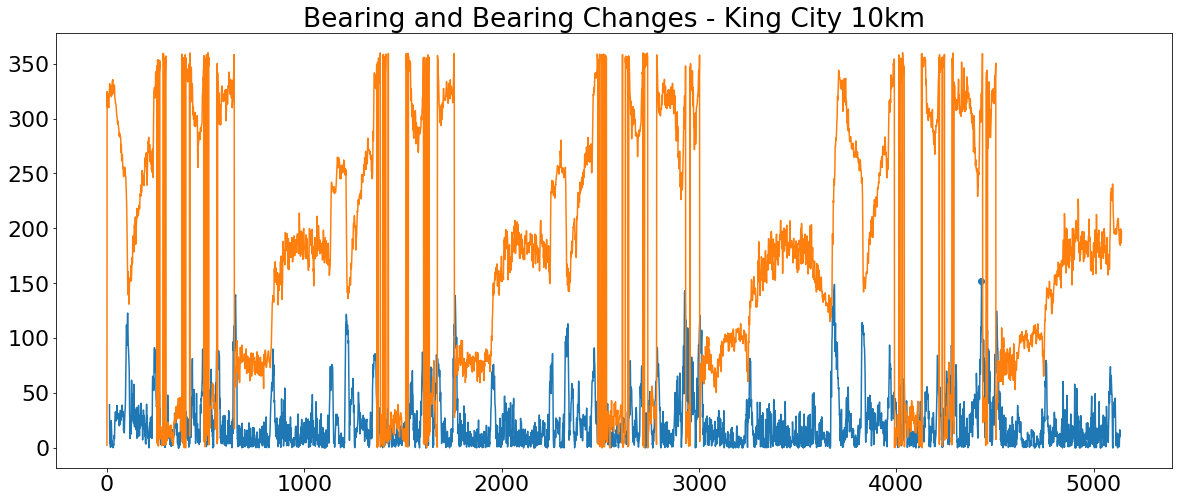

Standard Deviation
25.00802009817647
Total Degrees Turned
124457.40311915138
Race Distance/area of the course are 10365.704 m / -961627.1 m^2
Vincenty 3D :  10290.657185960195
Total Time :  97  min  25  sec 


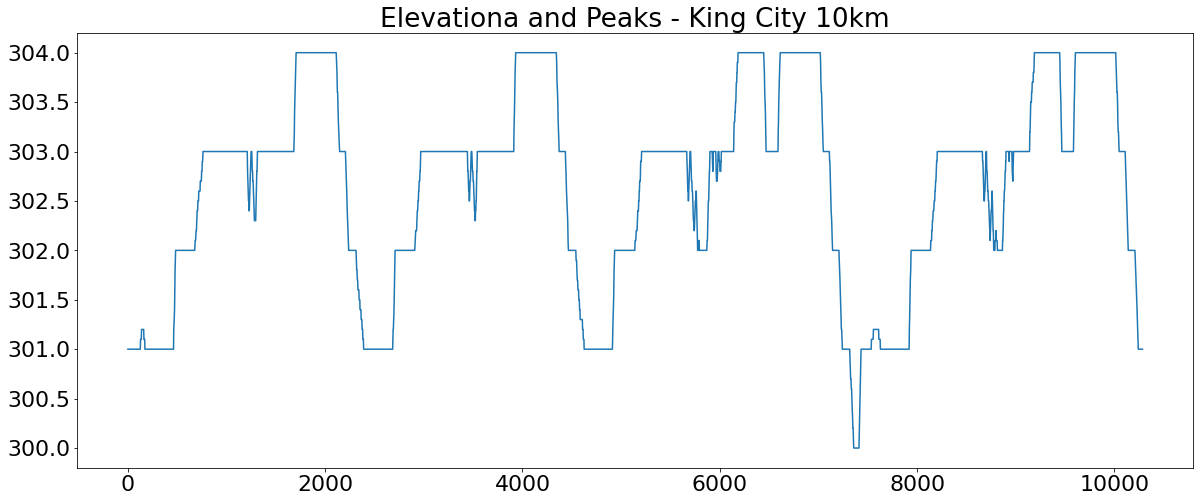

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Western International 10km.gpx
Interpolating ...
Number of hairpins in course
4


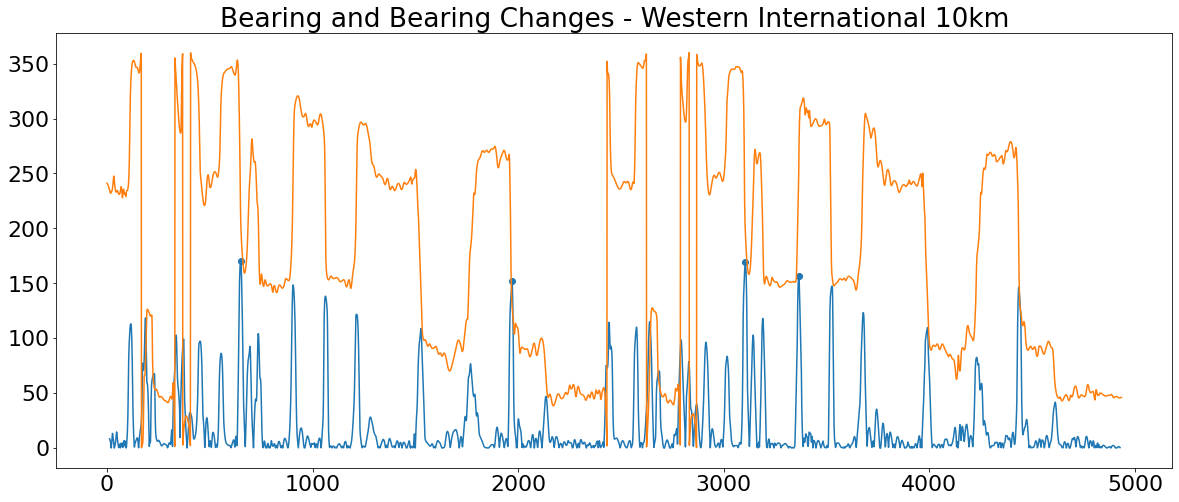

Standard Deviation
33.53918163507511
Total Degrees Turned
107063.69093055256
Race Distance/area of the course are 9995.070 m / 460585.0 m^2
Vincenty 3D :  9888.69833929203
Total Time :  33  min  53  sec 


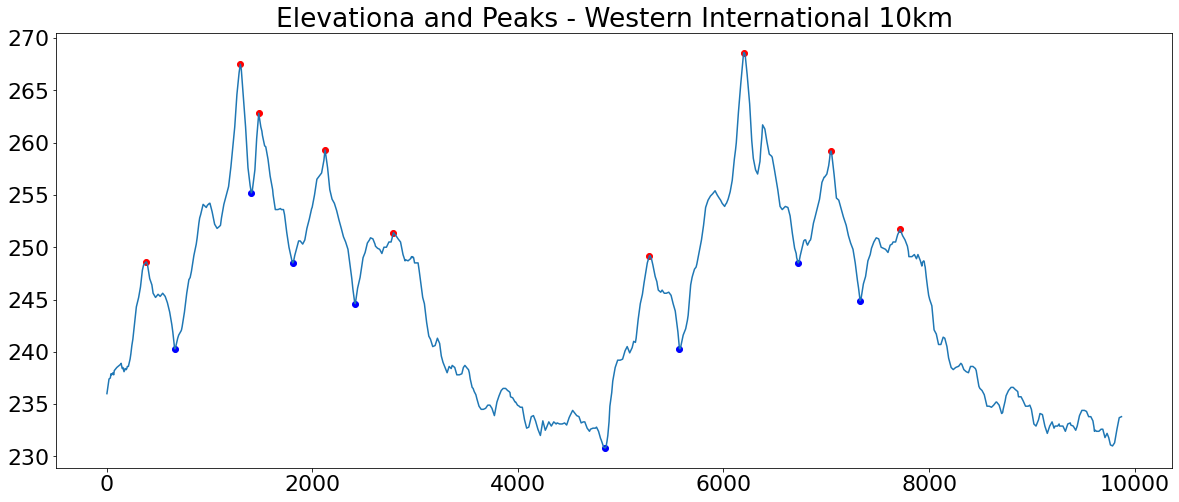

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Louisville Classic 8km.gpx
Interpolating ...
Number of hairpins in course
0


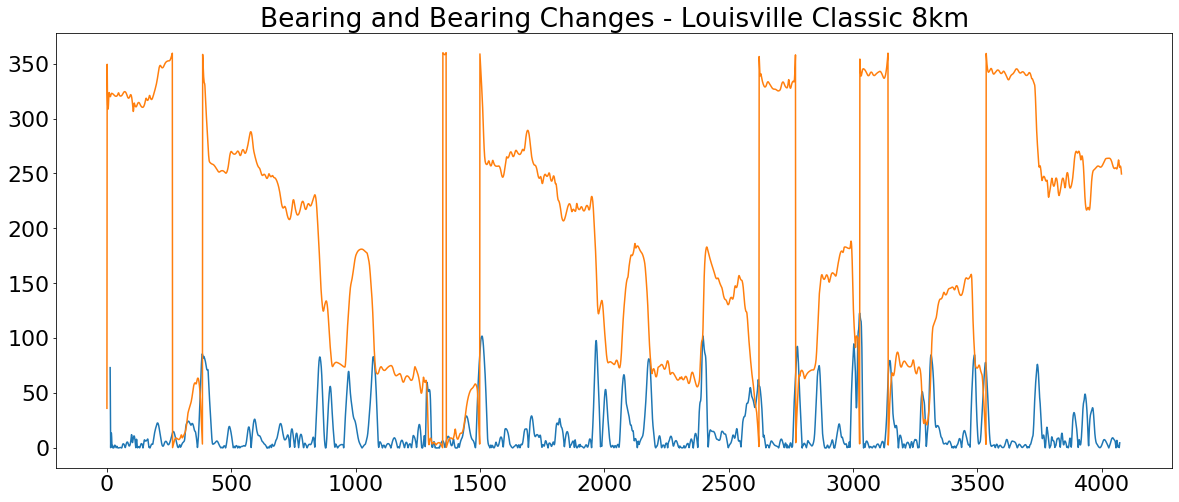

Standard Deviation
22.2837336800528
Total Degrees Turned
65813.16373870807
Race Distance/area of the course are 8564.184 m / 644055.3 m^2
Vincenty 3D :  8166.662627532945
Total Time :  26  min  10  sec 


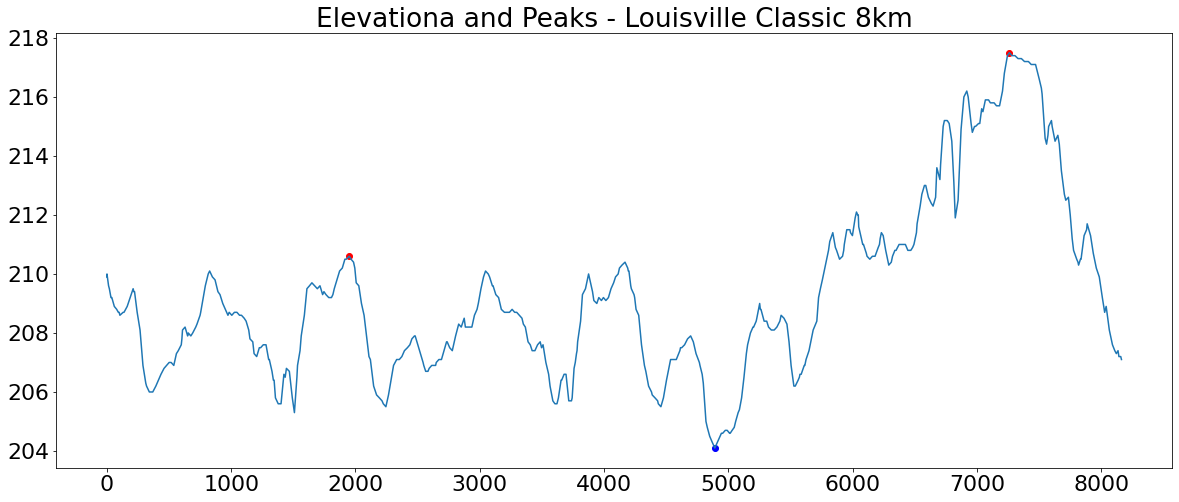

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Fort Henry 10km.gpx
Interpolating ...
Number of hairpins in course
4


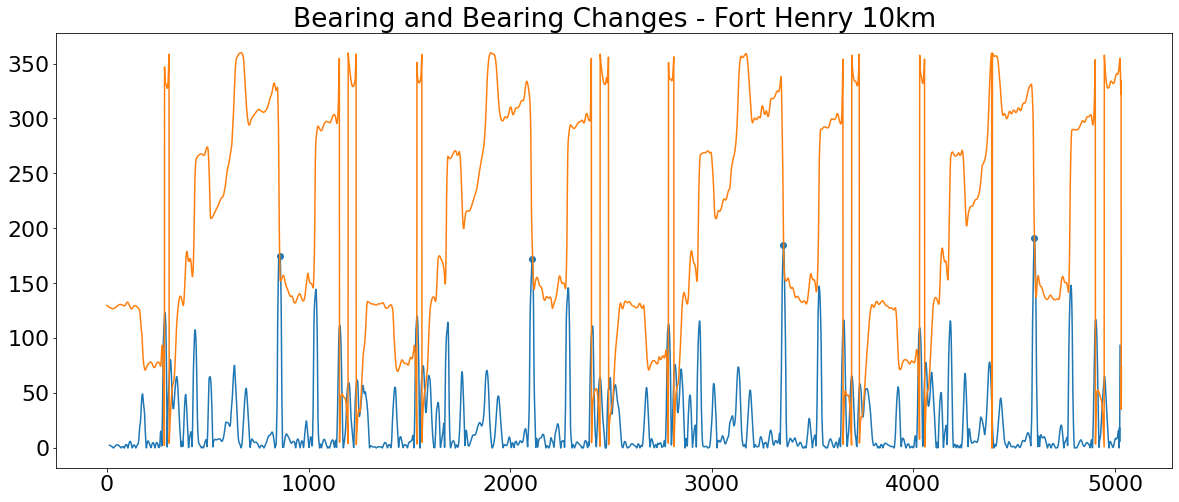

Standard Deviation
33.21071983115071
Total Degrees Turned
121117.15558384646
Race Distance/area of the course are 10146.846 m / -325336.8 m^2
Vincenty 3D :  10078.715677276085
Total Time :  35  min  33  sec 


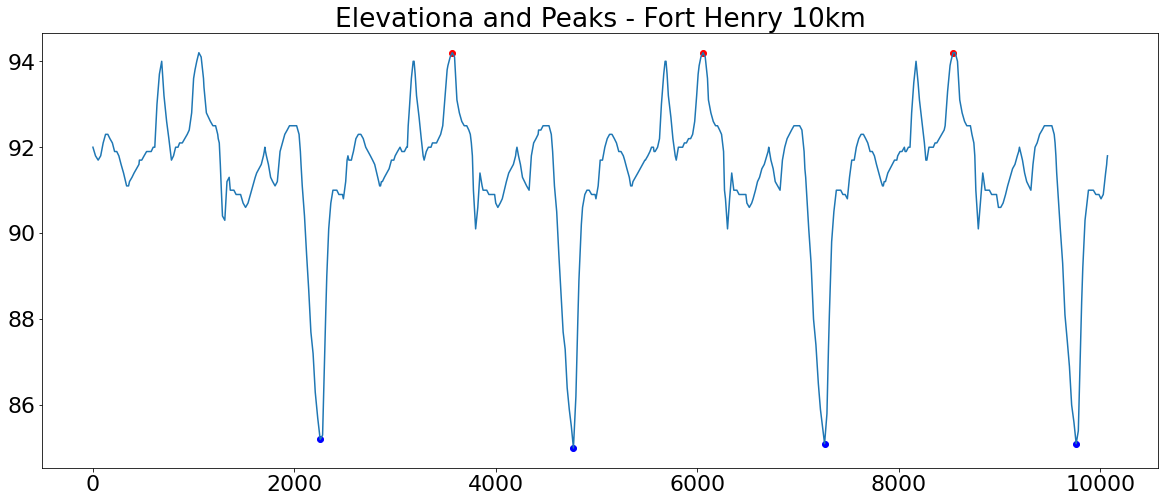

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Point Pleasant Park.gpx
Interpolating ...
Number of hairpins in course
14


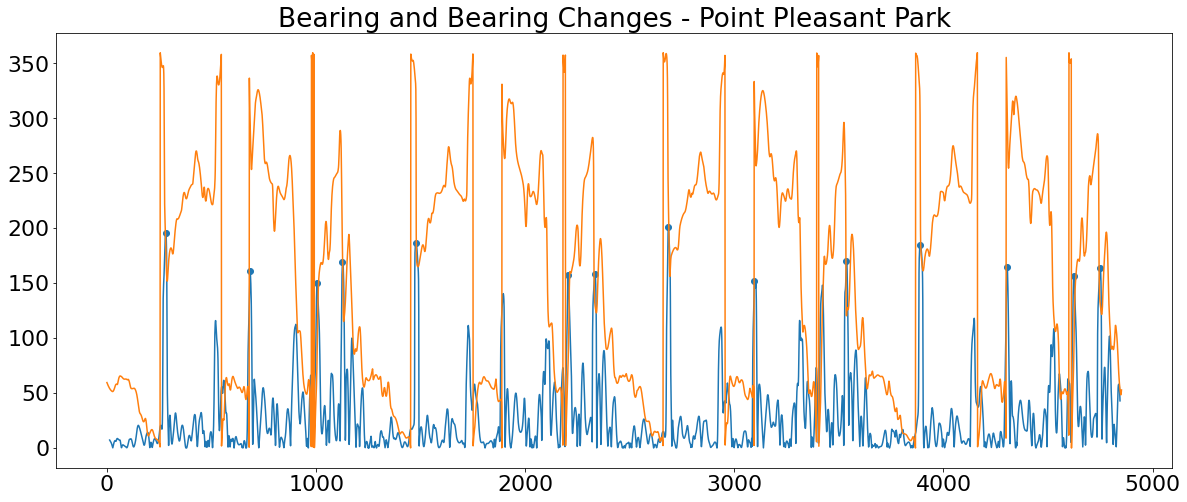

Standard Deviation
37.76421152193486
Total Degrees Turned
149565.77457126835
Race Distance/area of the course are 9833.651 m / 229523.5 m^2
Vincenty 3D :  9714.575104073932
Total Time :  34  min  14  sec 


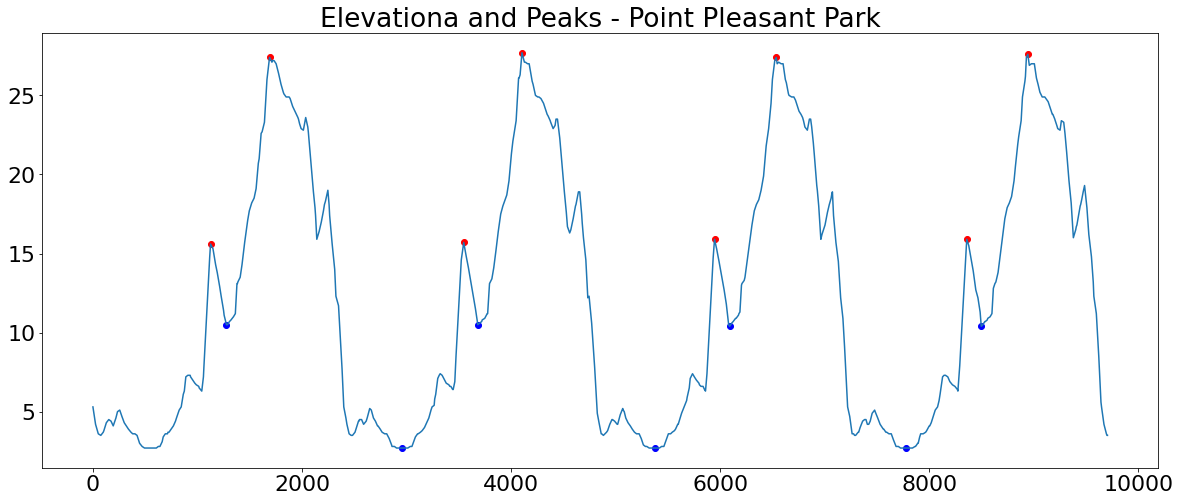

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Malden Park 10km.gpx
Interpolating ...
Number of hairpins in course
9


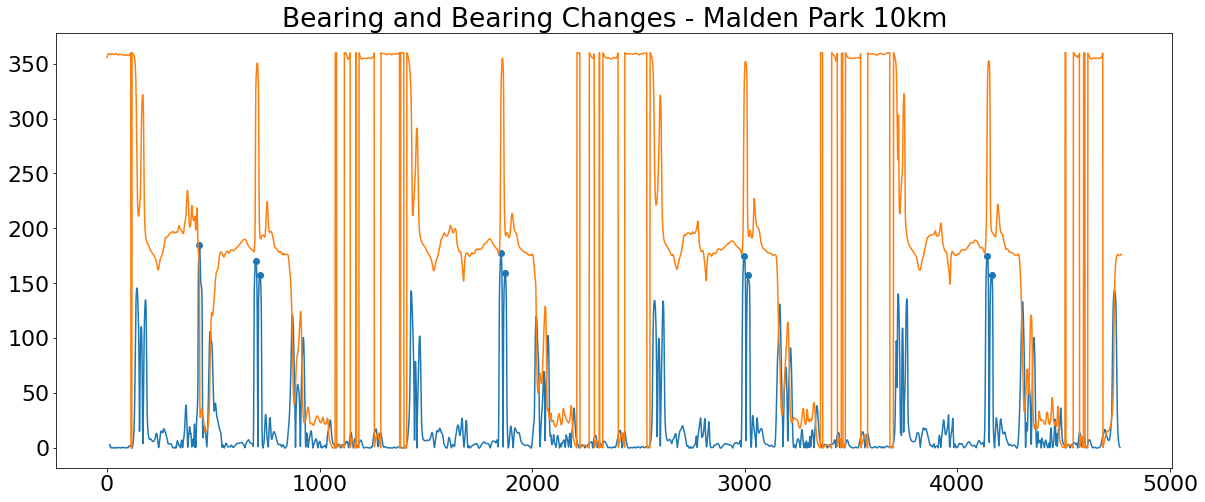

Standard Deviation
36.00910986447724
Total Degrees Turned
94586.13878299389
Race Distance/area of the course are 9676.019 m / -652511.8 m^2
Vincenty 3D :  9551.15176831382
Total Time :  32  min  43  sec 


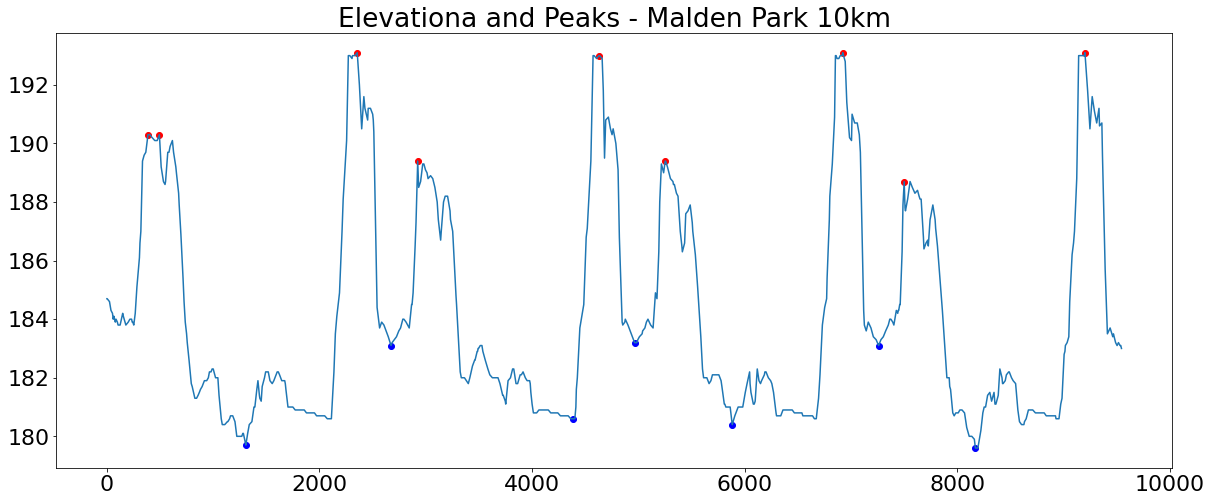

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
one hill error
hills
Moncton Classic 8km.gpx
Interpolating ...
Number of hairpins in course
4


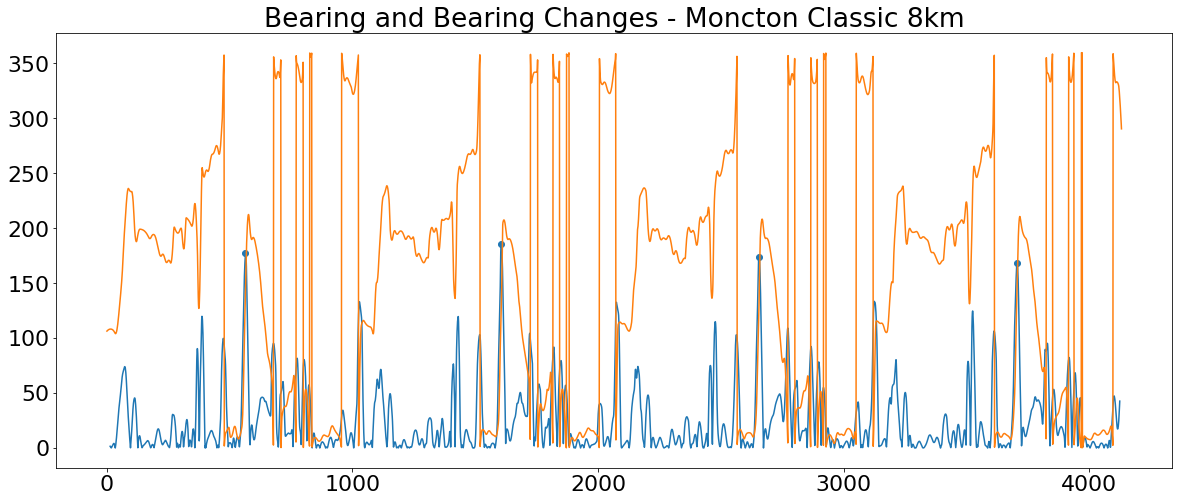

Standard Deviation
32.68980477641429
Total Degrees Turned
111237.32020398279
Race Distance/area of the course are 8364.974 m / 113177.2 m^2
Vincenty 3D :  8273.529756895965
Total Time :  29  min  58  sec 


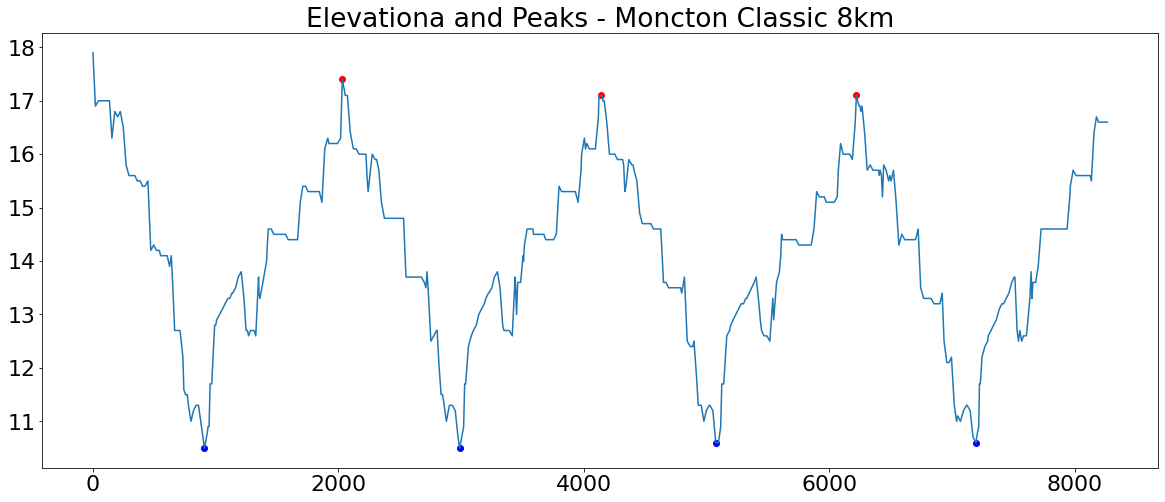

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Guelph Arboretum 7_5km.gpx
Interpolating ...
Number of hairpins in course
0


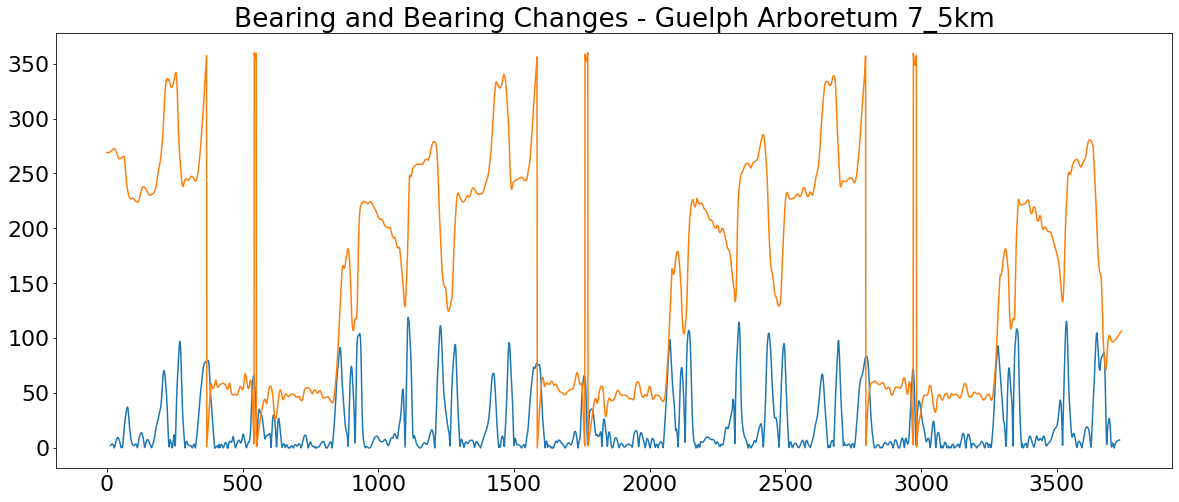

Standard Deviation
27.788016219171233
Total Degrees Turned
81815.02169035109
Race Distance/area of the course are 7567.653 m / -524346.6 m^2
Vincenty 3D :  7487.38940899223
Total Time :  24  min  13  sec 


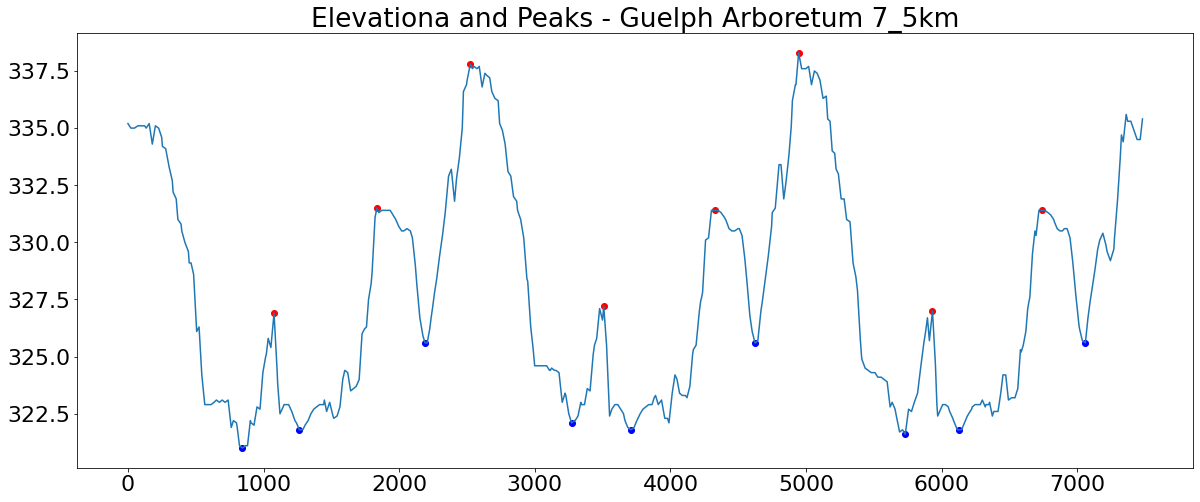

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Fanshawe Invitational 8km.gpx
Interpolating ...
Number of hairpins in course
5


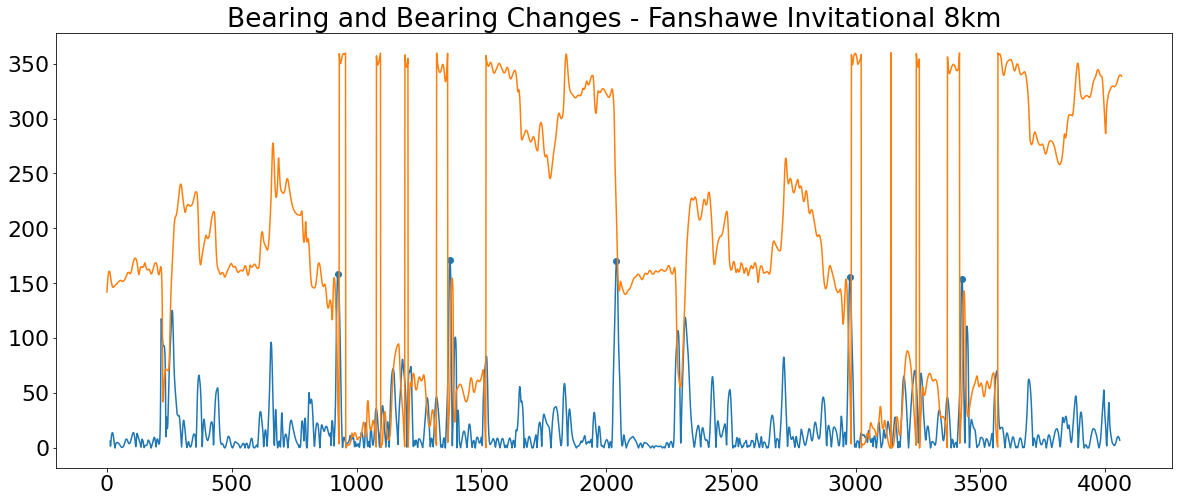

Standard Deviation
26.932202222785616
Total Degrees Turned
82266.77358453604
Race Distance/area of the course are 8189.232 m / 609485.1 m^2
Vincenty 3D :  8136.953076898368
Total Time :  30  min  6  sec 


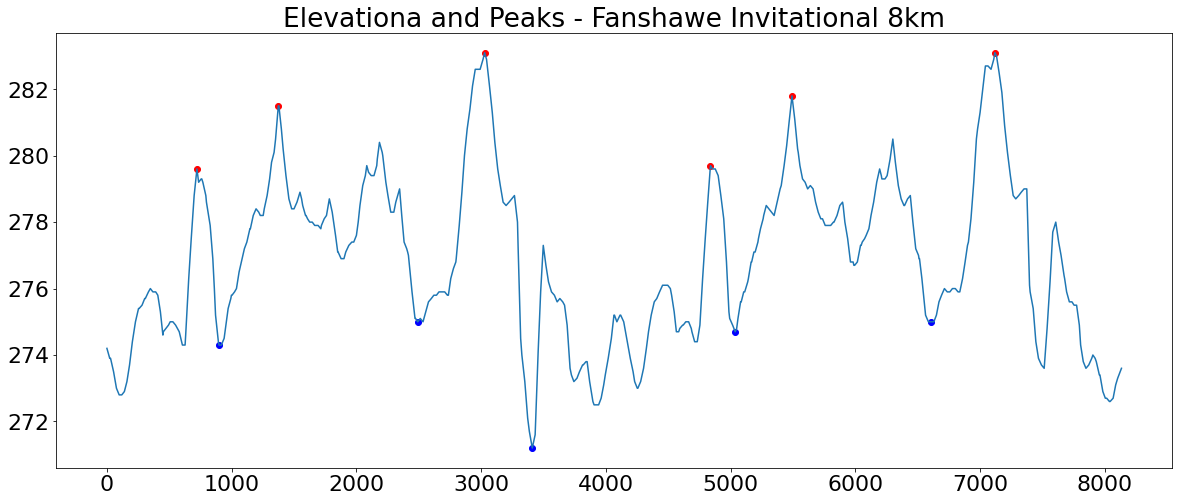

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
StFX Invitational 8km.gpx
Interpolating ...
Removed 198 duplicate trackpoint(s)
Number of hairpins in course
64


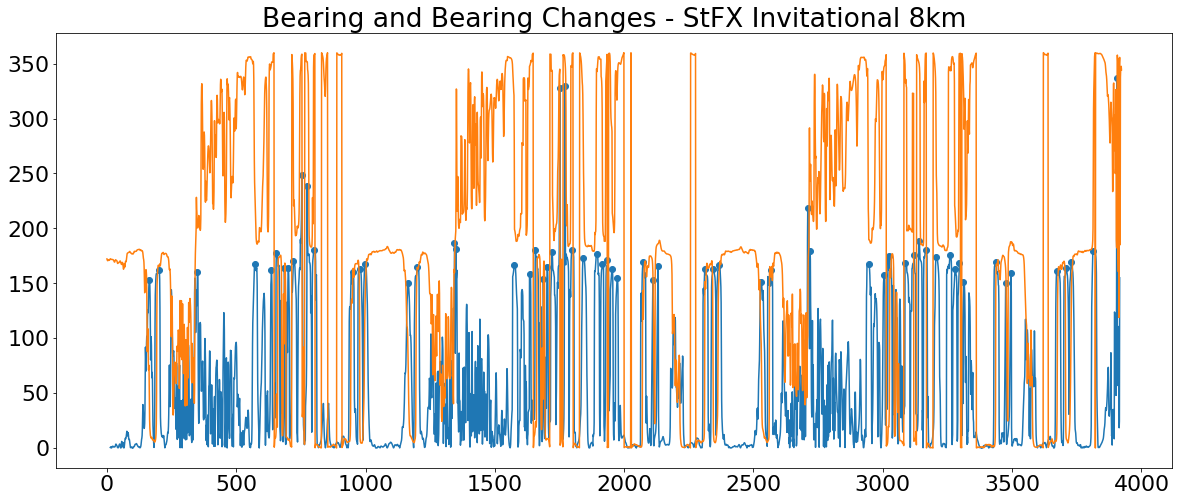

Standard Deviation
62.495828906995015
Total Degrees Turned
229882.1704813834
Race Distance/area of the course are 7877.891 m / 209506.5 m^2
Vincenty 3D :  7862.725770232105
Total Time :  29  min  30  sec 


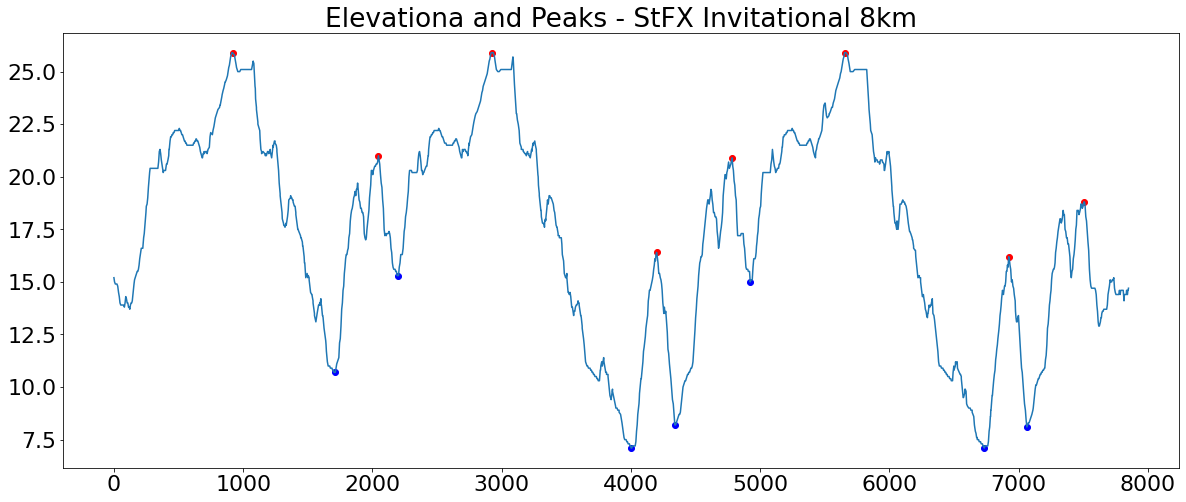

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Odell Park 7_5km.gpx
Interpolating ...
Number of hairpins in course
6


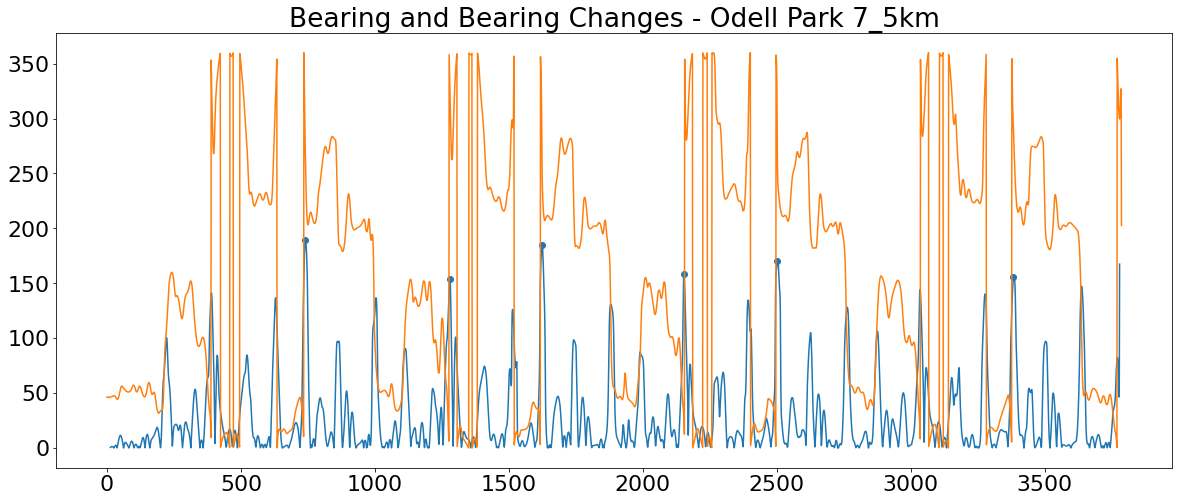

Standard Deviation
37.27974794149808
Total Degrees Turned
115887.4944061496
Race Distance/area of the course are 8069.542 m / -283638.7 m^2
Vincenty 3D :  7586.150777793854
Total Time :  29  min  10  sec 


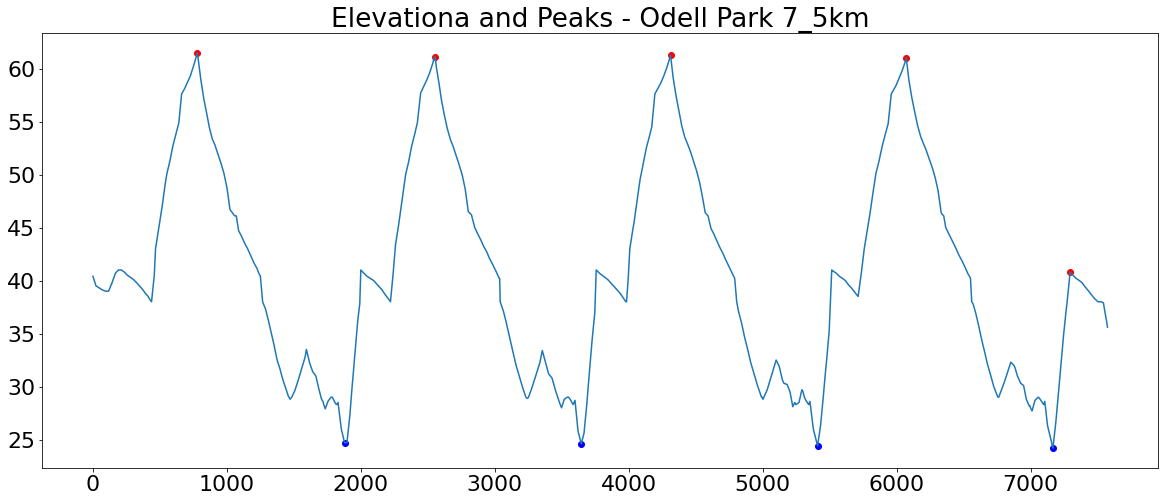

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Guelph Arboretum 10km.gpx
Interpolating ...
Removed 15 duplicate trackpoint(s)
Number of hairpins in course
0


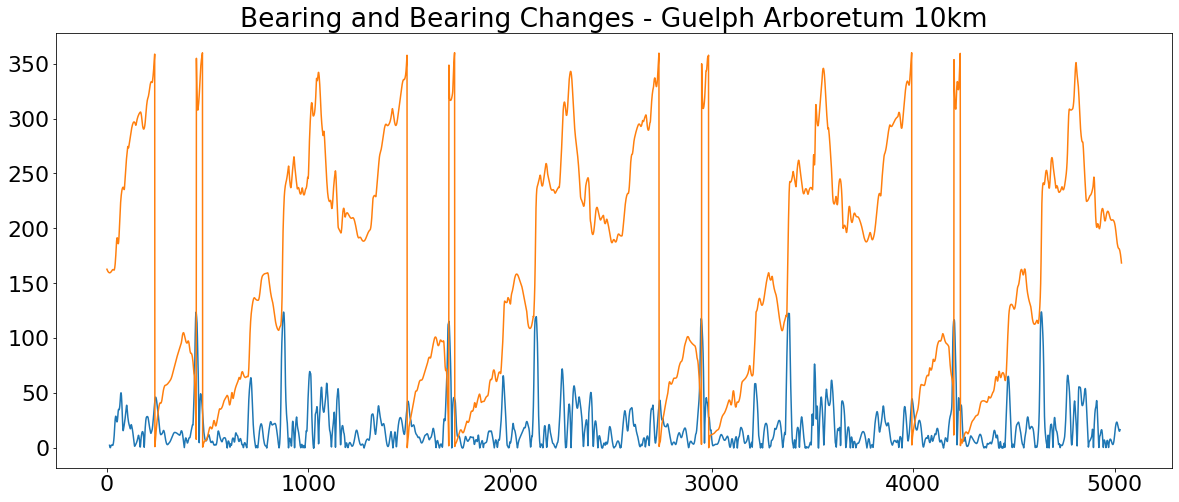

Standard Deviation
21.00831009209514
Total Degrees Turned
94949.70659429744
Race Distance/area of the course are 10158.209 m / -665799.1 m^2
Vincenty 3D :  10079.912043709823
Total Time :  33  min  27  sec 


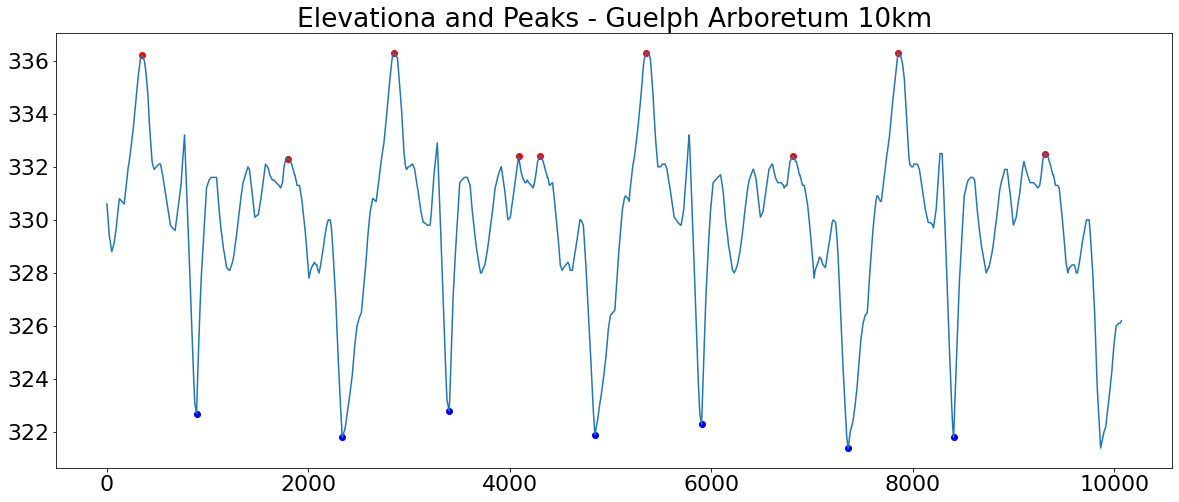

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
one hill error
hills
Loyola Lakefront 8km.gpx
Interpolating ...
Number of hairpins in course
2


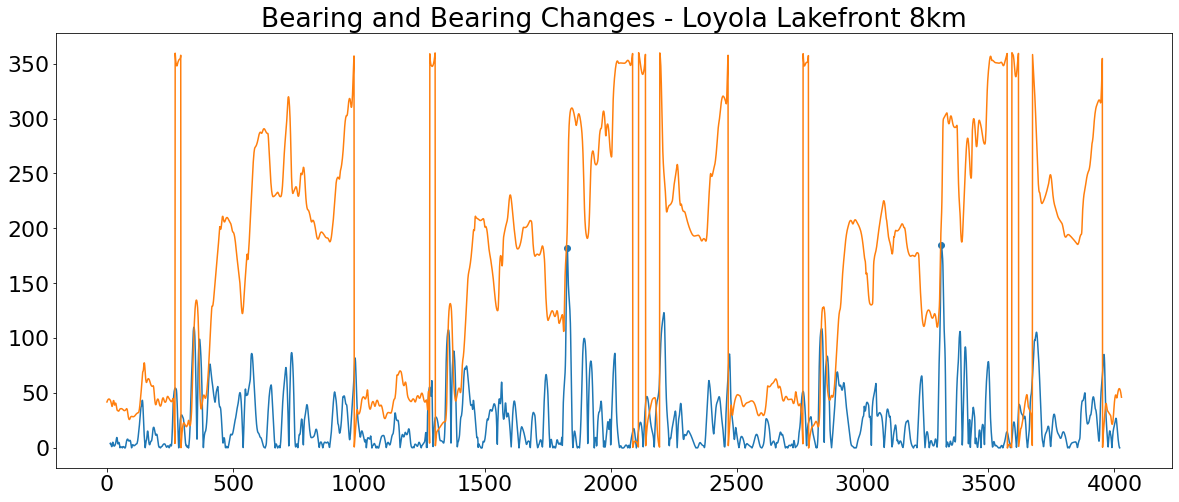

Standard Deviation
27.447188225322698
Total Degrees Turned
100769.8583089025
Race Distance/area of the course are 8189.048 m / 384133.9 m^2
Vincenty 3D :  8066.230812764311
Total Time :  26  min  20  sec 


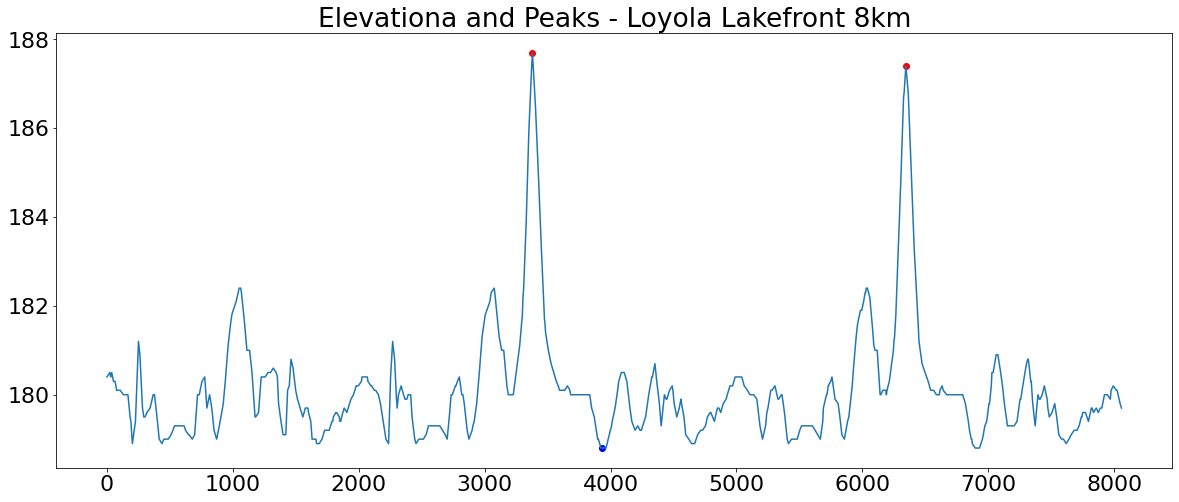

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Victoria Park 6km.gpx
Interpolating ...
Number of hairpins in course
3


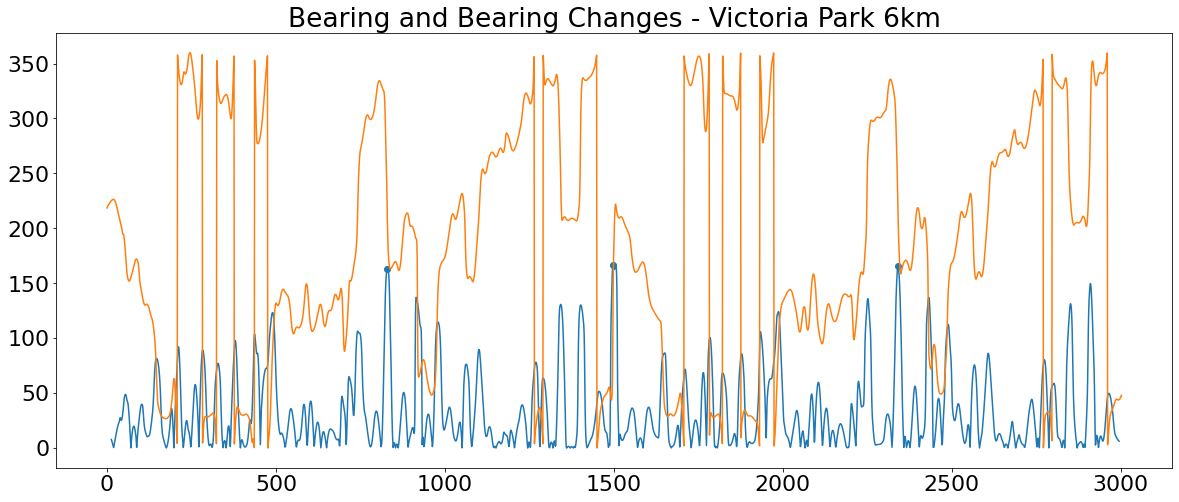

Standard Deviation
36.11775039638584
Total Degrees Turned
105894.24059515729
Race Distance/area of the course are 6073.875 m / 228575.9 m^2
Vincenty 3D :  6013.977734798533
Total Time :  21  min  13  sec 


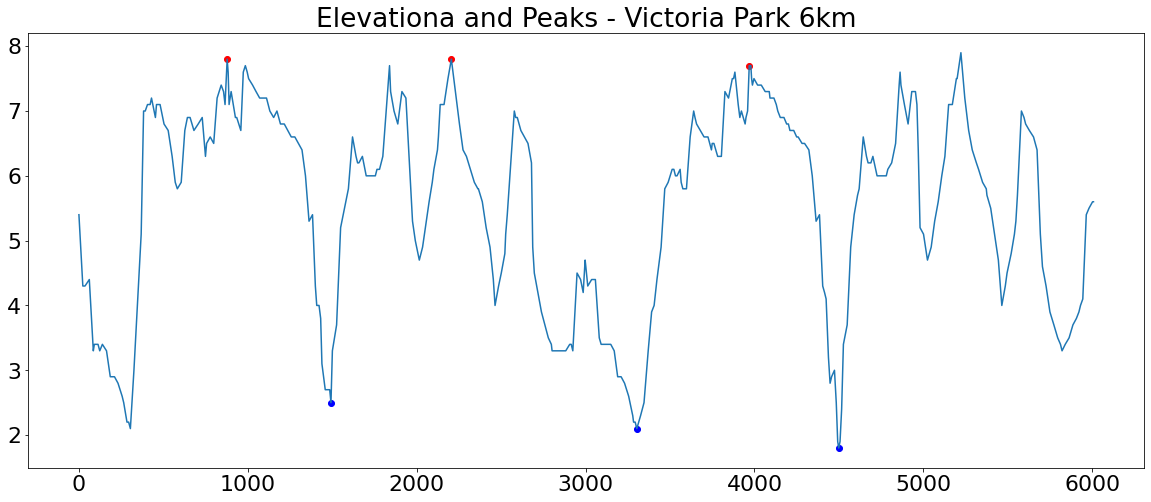

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Terre Haute 10km.gpx
Interpolating ...
Number of hairpins in course
10


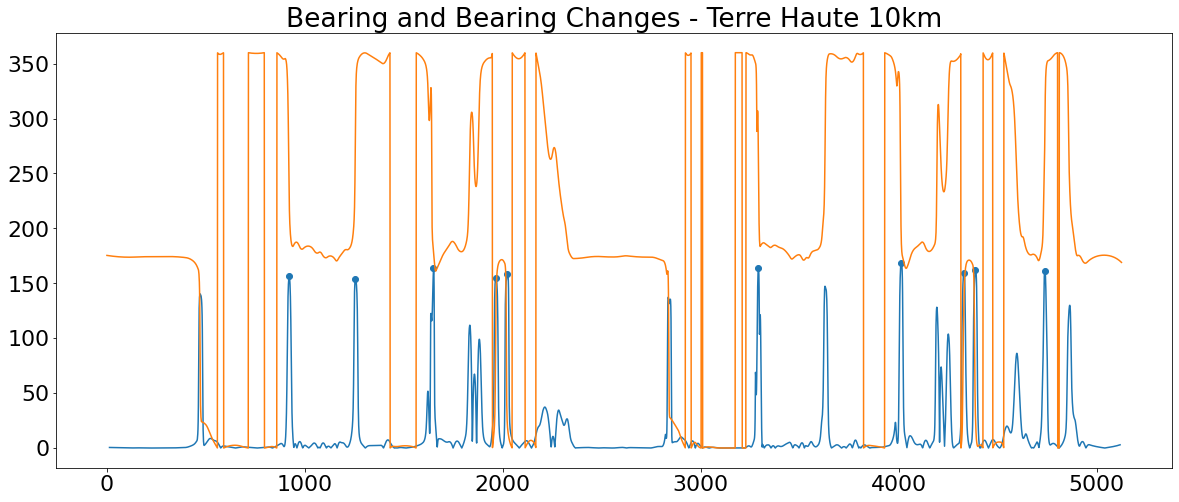

Standard Deviation
33.56084453981842
Total Degrees Turned
74719.58919341472
Race Distance/area of the course are 10696.043 m / -480729.6 m^2
Vincenty 3D :  10247.52736044531
Total Time :  0  min  0  sec 


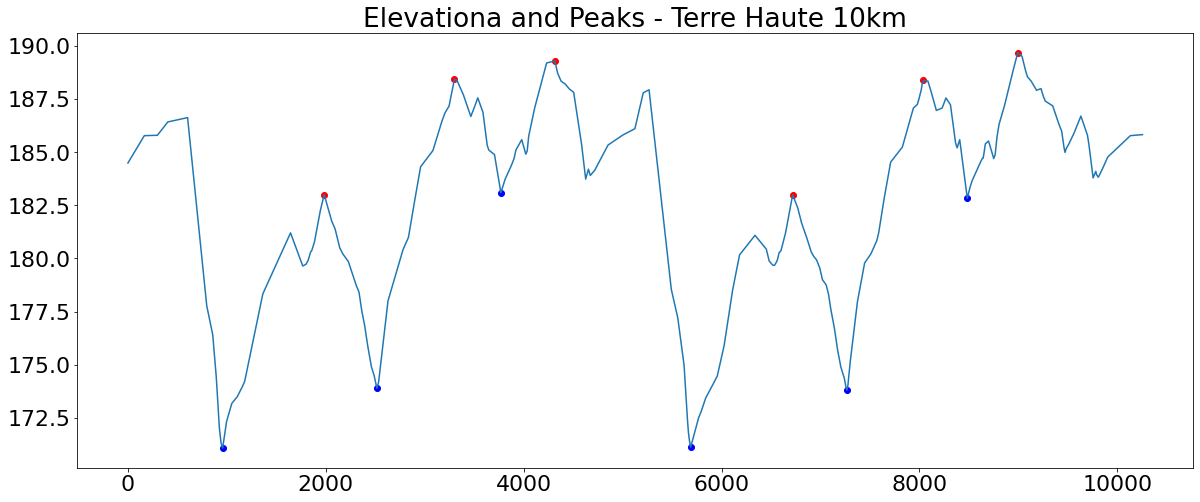

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Western International 8km.gpx
Interpolating ...
Number of hairpins in course
4


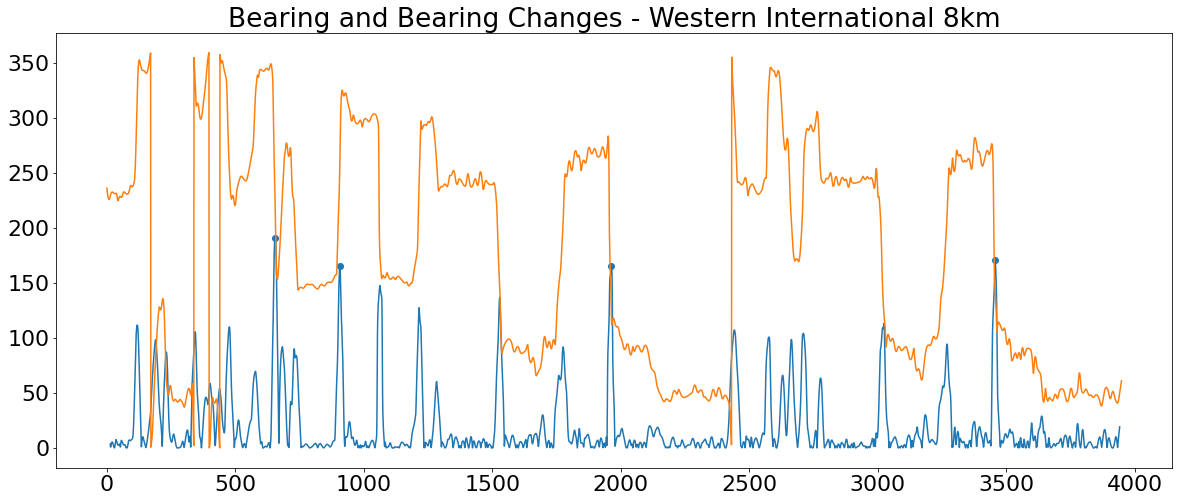

Standard Deviation
32.00005661098532
Total Degrees Turned
81807.96072635682
Race Distance/area of the course are 8033.752 m / 361108.3 m^2
Vincenty 3D :  7914.413549393357
Total Time :  26  min  44  sec 


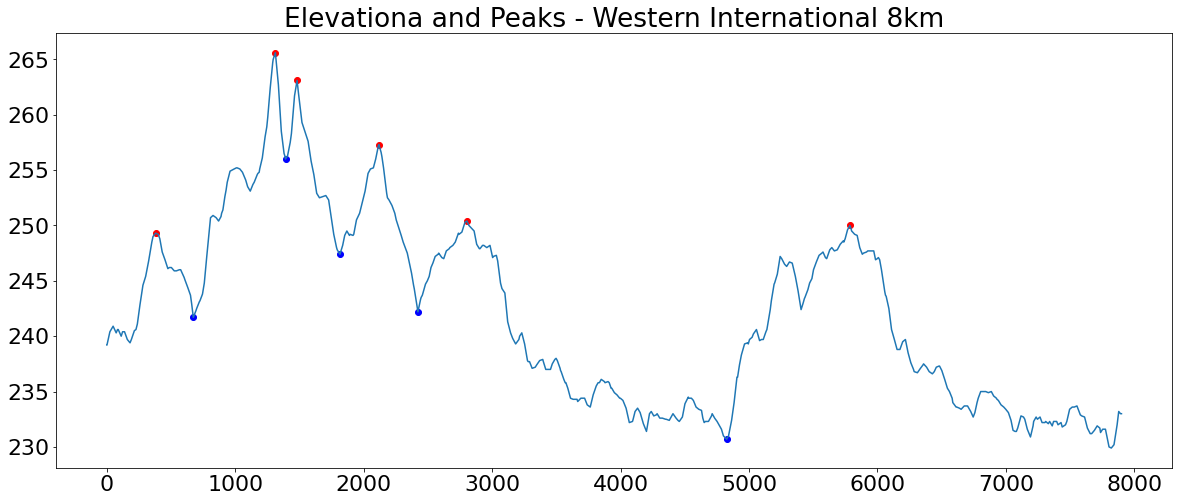

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills
Bayfront Park 7km.gpx
Interpolating ...
Removed 18 duplicate trackpoint(s)
Number of hairpins in course
13


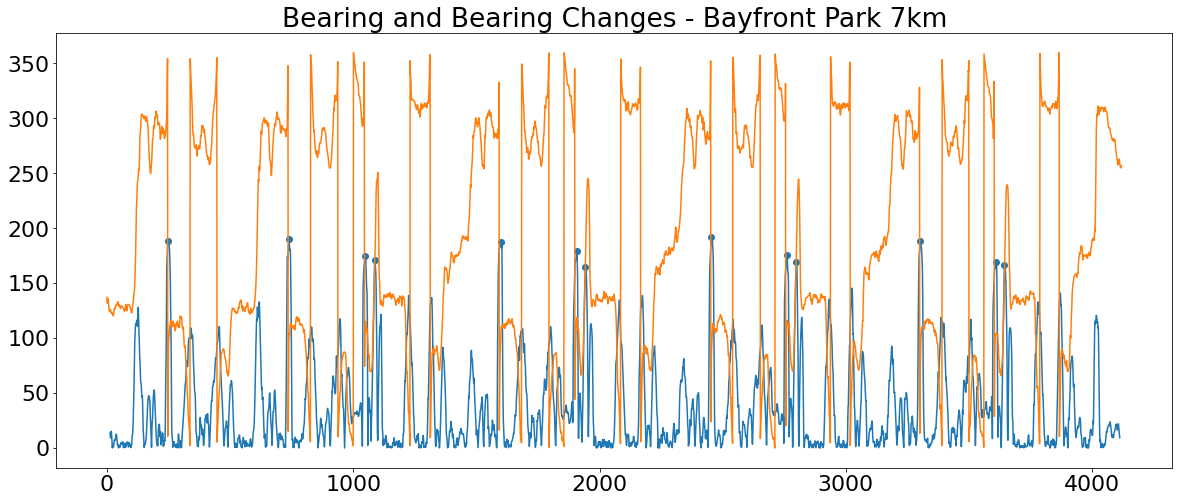

Standard Deviation
44.77006746876065
Total Degrees Turned
168622.33693395724
Race Distance/area of the course are 8320.510 m / -143976.4 m^2
Vincenty 3D :  8252.315947120258
Total Time :  29  min  39  sec 


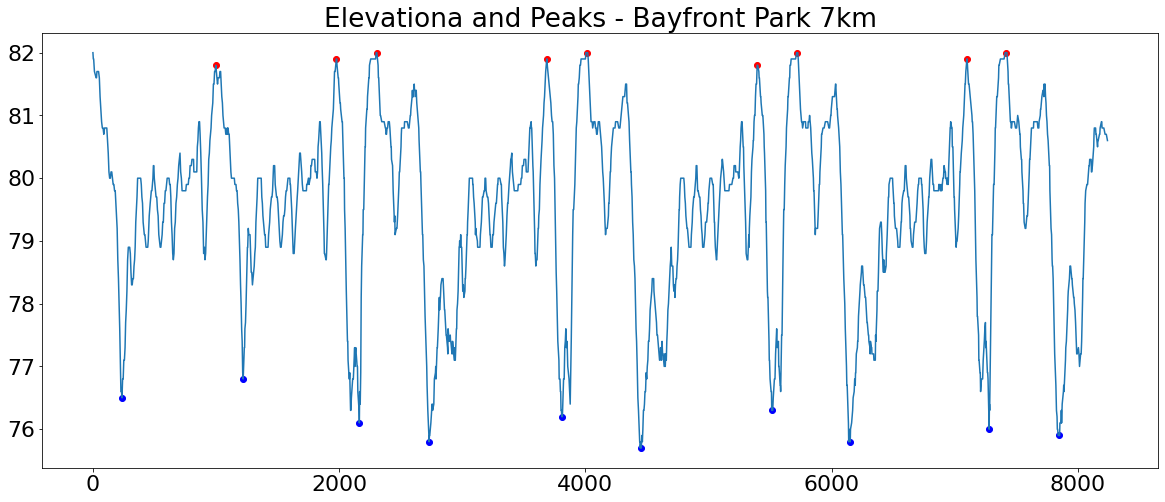

Index(['Lat', 'Lon', 'Elevation', 'dis_vin_2d', 'dist_hav_2d', 'dis_vin_3d',
       'alt_dif', 'time_dif', 'dis_dif_hav_2d', 'dis_dif_vin_2d'],
      dtype='object')
hills


In [22]:
path = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/'
directory = os.fsencode(path)
    
courses = []
st_devs = []
tot_deg_turneds = []
perims = []
areas = []
num_hairpins = []
dfs = []
tallest_hills = []
num_hills_list = []
turn_st_devs = []
hill_st_devs = []
tot_elev_gains = []
tot_elev_gain_unfiltereds = []
hill_dfs = []
lengthoftallesthill = []
start_loc_list = []
start_lat_list = []
start_lon_list = []


for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".gpx"): 
        
        print(filename)
        
        base=os.path.basename(path + filename)
        course = os.path.splitext(base)[0]
        courses.append(course)
        
        gpx_file = path + filename
        gpx_data = gpx_interpolate.gpx_read(gpx_file)
        gpx_data_interp = gpx_interpolate.gpx_interpolate(gpx_data, res=2, deg = 3)
        
        window = 20 #meters long to consider a hairpin turn complete
        df, bearing = angle_diff(gpx_data_interp, window)
        
        height = 150 #number of degrees in a hairpin turn over the window length
        turn_st_dev, tot_deg_turned, num_peak = hairpin_detection(df, height, bearing, gpx_data_interp, course)
        
        perim, area = course_area(geod, df)
        
        turn_st_devs.append(turn_st_dev)
        tot_deg_turneds.append(tot_deg_turned)
        perims.append(perim)
        areas.append(area)
        num_hairpins.append(num_peak)
        
        #get the elevation and distance
        gpx = gpxfile_to_gpx(path, filename)
        lat, lon, ele = gpx_to_lat_lon(gpx)
        df = pd.DataFrame({'Lat': lat, 'Lon': lon, 
                   'Elevation': ele})
        df = add_distance(gpx, df)
        df.set_index('dis_hav_3d', inplace=True)
         
#         course_max_min(df) #plot the course max and min
        
#         #get the hills
#         min_vals, max_vals, hill_climbs, hill_lengths, df = hills(df)
#         print('hills')
#         print(hill_climbs, hill_lengths)
        
        hill_min_height = 5
        length_of_hill = 5
        hill_st_dev, peaks, mins, tot_elev_gain, tot_elev_gain_unfiltered = hills_peaks(df, hill_min_height, length_of_hill, course)
        hill_st_devs.append(hill_st_dev)
        tot_elev_gains.append(tot_elev_gain)
        tot_elev_gain_unfiltereds.append(tot_elev_gain_unfiltered)
        
        print(df.columns)
        min_vals, max_vals, hill_climbs, hill_lengths = hill_details(df, peaks, mins)
        print('hills')
        hill_grade = np.divide(hill_climbs, hill_lengths)*100
        # put all of the hill details into a dataframe of some sort so that we can compare the different sites
        hill_df = pd.DataFrame({'Hill Height': hill_climbs, 'Hill Distance': hill_lengths, 'Hill Grade': hill_grade})
        #drop hills with too low of a grade
        hill_df.drop(hill_df[hill_df['Hill Grade'] < 1].index, inplace=True)
        hill_df.reset_index(drop=True, inplace=True)
        num_hills = len(hill_df)
        
        #list of tallest hill for each course
        tallest_hills.append(hill_df['Hill Height'].max())
        if len(hill_df)>0: #check if there are any hills
            lengthoftallesthill.append(hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'].min())
        else:
            lengthoftallesthill.append(np.nan)
        hill_dfs.append(hill_df)
        num_hills_list.append(num_hills)
        start_lat_list.append(lat[0])
        start_lon_list.append(lon[0])
        
        dfs.append(df)
        
course_info_df = pd.DataFrame({'Course': courses, 'Turn Stdev': turn_st_devs, 
                               'Total Degrees Turned': tot_deg_turneds, 'Perimeters/Total Distance': perims,
                              'Course Area (m^2)': areas, 'Number of Hairpin Turns': num_hairpins, 'Hill Stdev': hill_st_devs,
                              'Tallest Hill (m)': tallest_hills, 'Length of tallest hill (m)': lengthoftallesthill, 'Number of Hills': num_hills_list,
                              'Total Elevation Gain (m)': tot_elev_gains, 'Total Elevation Gain Unfiltered (m)': tot_elev_gain_unfiltereds,
                              'Start Lat': start_lat_list, 'Start Lon': start_lon_list})
course_info_df['Course Area (m^2)'] = course_info_df['Course Area (m^2)'].abs() #sometiems area is negative


In [23]:
# hill_dfs[1]
# hill_df['Hill Height'].max()
hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'].min()
# max(hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'])
# len(hill_df)
# hill_df[hill_df['Hill Height']==max(hill_df['Hill Height'])]['Hill Distance'].item()
# hill_df

134.96767427172745

In [24]:
course_info_df.sort_values(by=['Total Elevation Gain (m)'], ascending=False)

Course  Turn Stdev  Total Degrees Turned  \
10            Odell Park 7_5km   37.279748         115887.494406   
1   Western International 10km   33.539182         107063.690931   
4          Point Pleasant Park   37.764212         149565.774571   
11       Guelph Arboretum 10km   21.008310          94949.706594   
15   Western International 8km   32.000057          81807.960726   
7       Guelph Arboretum 7_5km   27.788016          81815.021690   
5             Malden Park 10km   36.009110          94586.138783   
9        StFX Invitational 8km   62.495829         229882.170481   
14            Terre Haute 10km   33.560845          74719.589193   
8    Fanshawe Invitational 8km   26.932202          82266.773585   
3              Fort Henry 10km   33.210720         121117.155584   
16           Bayfront Park 7km   44.770067         168622.336934   
2       Louisville Classic 8km   22.283734          65813.163739   
12        Loyola Lakefront 8km   27.447188         100769.858309   
6          Moncton Classic 8km   32.689805         111237.320204   
13           Victoria Park 6km   36.117750         105894.240595   
0               King City 10km   25.008020         124457.403119   

    Perimeters/Total Distance  Course Area (m^2)  Number of Hairpin Turns  \
10                8069.542451      283638.745914                        6   
1                 9995.069748      460585.033714                        4   
4                 9833.651106      229523.489920                       14   
11               10158.208686      665799.101867                        0   
15                8033.751573      361108.317223                        4   
7                 7567.653255      524346.636078                        0   
5                 9676.018510      652511.773439                        9   
9                 7877.891420      209506.497672                       64   
14               10696.042597      480729.555165                       10   
8                 8189.231553      609485.120894                        5   
3                10146.846494      325336.824553                        4   
16                8320.510372      143976.390352                       13   
2                 8564.183636      644055.301738                        0   
12                8189.048459      384133.922462                        2   
6                 8364.974452      113177.231313                        4   
13                6073.874754      228575.908262                        3   
0                10365.704055      961627.116177                        1   

    Hill Stdev  Tallest Hill (m)  Length of tallest hill (m)  Number of Hills  \
10    9.938622             36.70                  666.219110                5   
1     8.938636             28.30                  624.186839                9   
4     8.136408             17.20                  445.672248                7   
11    3.012351             14.50                  514.412999                4   
15    8.304549             23.90                  639.196565                6   
7     4.864457             12.70                  322.013072                8   
5     3.697679              5.60                  391.032791                1   
9     4.821614             12.70                  443.548096                8   
14    4.972641             14.58                  773.305939                6   
8     2.464474              8.10                  510.489664                4   
3     1.567794               NaN                         NaN                0   
16    1.484960              6.00                  134.967674                4   
2     2.971927               NaN                         NaN                0   
12    1.244331               NaN                         NaN                0   
6     1.678552               NaN                         NaN                0   
13    1.593101               NaN                         NaN                0   
0     1.014632               NaN   

### Plot the courses on a map

In [ ]:
# !conda install basemap
!conda install -c anaconda basemap

Solving environment: done

## Package Plan ##

  environment location: /Users/jeremywalsh/anaconda3

  added / updated specs:
    - basemap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-1.3.0              |   py37hc4b8d57_0        15.2 MB  anaconda
    ca-certificates-2020.6.24  |                0         132 KB  anaconda
    certifi-2020.6.20          |           py37_0         159 KB  anaconda
    geos-3.8.0                 |       hb1e8313_0         895 KB  anaconda
    openssl-1.1.1g             |       h1de35cc_0         3.4 MB  anaconda
    proj-6.2.1                 |       hfd5b9e3_0        10.1 MB  anaconda
    pyproj-2.6.1.post1         |   py37h6d9c95c_1         375 KB  anaconda
    pyshp-2.1.2                |             py_0          35 KB  anaconda
    ------------------------------------------------------------
                                           Total:

In [ ]:
from mpl_toolkits.basemap import Basemap

In [ ]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)

# # Map (long, lat) to (x, y) for plotting
# x, y = m(-122.3, 47.6)
# plt.plot(x, y, 'ok', markersize=5)
# plt.text(x, y, ' Seattle', fontsize=12);

for index, row in course_info_df.iterrows():
    x, y = m(row['Lon'], row['Lat'])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, row['Course'], fontsize=12)
    plt.show()

In [ ]:
# Turns
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Turn Stdev'], course_info_df['Total Degrees Turned'], color='red', label='Total Degrees Turned')
ax.set_ylabel('Degrees Turned', color='red')
ax.set_xlabel('Turn Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Turn Stdev'], course_info_df['Course Area (m^2)'], color='blue', label='Course Area')
ax2.set_ylabel('Course Area (m^2)', color='blue')
plt.show()

# Hills
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Hill Stdev'], course_info_df['Total Elevation Gain (m)'], color='red')
ax.set_ylabel('Elevation Gain', color='red')
ax.set_xlabel('Hill Standard Deviation')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(course_info_df['Hill Stdev'], course_info_df['Number of Hills'], color='blue')
ax2.set_ylabel('# of Hills', color='blue')
plt.show()


fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(course_info_df['Total Elevation Gain Unfiltered (m)'], course_info_df['Total Elevation Gain (m)'], color='red')
ax.set_ylabel('Filtered')
ax.set_xlabel('Unfiltered')
plt.show()

In [ ]:
# course_info_df['Length of tallest hill (m)'][1]
course_info_df

In [ ]:
# Hills
fig = plt.figure(figsize=(20, 15))
# plt.scatter(course_info_df['Length of tallest hill (m)'], course_info_df['Tallest Hill (m)'], color='red')
for i in range(len(course_info_df)):
    plt.fill_between([0,course_info_df['Length of tallest hill (m)'][i]],[0,0],[0,course_info_df['Tallest Hill (m)'][i]], alpha=0.3, label=course_info_df['Course'][i])
plt.ylabel('Height (m)')
plt.xlabel('Length of hill (m)')
plt.legend(loc="upper left")
plt.xlim(0)
plt.ylim(0)
plt.show()


In [ ]:
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Patch, Plot
from bokeh.io import output_notebook
from bokeh.layouts import column
output_notebook()

In [ ]:
N = 30
plots = []
# for i in range(len(course_info_df)):
p = figure()
x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
x2 = x1[::-1]
y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
y2 = np.linspace(0, 0, N)
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

source = ColumnDataSource(dict(x=x, y=y))

plot = Plot(
    title=None, plot_width=300, plot_height=300,
    min_border=0, toolbar_location=None)

glyph = Patch(x="x", y="y", fill_color="#a6cee3")
plot.add_glyph(source, glyph)

#another one
i=2
x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
x2 = x1[::-1]
y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
y2 = np.linspace(0, 0, N)
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

source = ColumnDataSource(dict(x=x, y=y))

plot = Plot(
    title=None, plot_width=300, plot_height=300,
    min_border=0, toolbar_location=None)

glyph = Patch(x="x", y="y", fill_color="#a6cee3")
plot.add_glyph(source, glyph)
    
#     plots.append(p)

    
#     glyphs = [p.line(np.arange(10), np.random.random(10)) for j in range(2)]
#     plots.append(p)
#     show(column(*plots))

xaxis = LinearAxis()
plot.add_layout(xaxis, 'below')

yaxis = LinearAxis()
plot.add_layout(yaxis, 'left')

plot.add_layout(Grid(dimension=0, ticker=xaxis.ticker))
plot.add_layout(Grid(dimension=1, ticker=yaxis.ticker))

curdoc().add_root(plot)

show(plot)
# show(column(*plots))

In [ ]:
from bokeh.plotting import figure, curdoc
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20, Spectral6, Inferno256, Viridis256
import time

xs, ys = [], []

for i in range(len(course_info_df)):
    x1 = np.linspace(0, course_info_df['Length of tallest hill (m)'][i], N)
    x2 = x1[::-1]
    y1 = np.linspace(0, course_info_df['Tallest Hill (m)'][i], N) 
    y2 = np.linspace(0, 0, N)
    x = np.hstack((x1, x2))
    y = np.hstack((y1, y2))
    xs.append(x)
    ys.append(y)

plot = figure(plot_width=900, plot_height=600)
# mapper = linear_cmap(field_name='y', palette=Category20, low=min(ys) ,high=max(ys))
# mapper = linear_cmap(field_name='ys', palette=Viridis256, low=0 ,high=max(y)) 
# plot.patches(xs=xs, ys=ys, fill_color=mapper, alpha=0.1)

source = ColumnDataSource(dict(
    xs=xs,
    ys=ys,
    color=Category20[len(ys)],
    label=list(course_info_df['Course'])
))
# color=[c1, c2, c1, c2],

# Note legend field matches the column in `source`
plot.patches( xs='xs', ys='ys', color='color', legend='label', source=source, alpha=0.2)


plot.legend.location = "top_left"
# plot.legend.click_policy="hide" #interactive legends don't work for grouped glyphs

# print(time.time() - start_time)

curdoc().add_root(plot)
show(plot)

# drop all hills that aren't enough height over

# next step is to classify all the hills in terms of their length and height, and then filter for hills being of a certain lenght and height

In [ ]:
# df['Elevation']

### Cleaning up srtm. Not helpful right now

In [ ]:
!pip install SRTM.py
import srtm

In [ ]:
filename = 'King City 10km.gpx'

In [ ]:
# Raw GPS.
gpx = gpxfile_to_gpx(path, filename)
lat, lon, raw_ele = gpx_to_lat_lon(gpx)

# Raw SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx)
lat, lon, srtm_ele = gpx_to_lat_lon(gpx)

# Smoothed SRTM.
gpx = gpxfile_to_gpx(path, filename)
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx, smooth=True)
lat, lon, smooth_ele = gpx_to_lat_lon(gpx)

In [ ]:
import seaborn

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(raw_ele, label='Raw GPS')
ax.plot(srtm_ele, label='SRTM')
ax.plot(smooth_ele, label='Smoothed SRTM')
l = ax.legend()

In [ ]:
from scipy.signal import lfilter
from scipy.signal import savgol_filter

n = 40  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b,a,df['Elevation'])

n=30 # number of points to be checked before and after 
# Find local peaks

df['Elevation Filtered'][n:] = yy[n:]
df['min'] = df.iloc[argrelextrema(yy, np.less_equal, order=n)[0]]['Elevation Filtered']
df['max'] = df.iloc[argrelextrema(yy, np.greater_equal, order=n)[0]]['Elevation Filtered']



fig = plt.figure(figsize=(20,8))
plt.plot(df['dis_hav_3d'], dydx, label='1st Derivative')
plt.scatter(df['dis_hav_3d'], df['min'], c='r')
plt.scatter(df['dis_hav_3d'], df['max'], c='g')
plt.plot(df['dis_hav_3d'], yy, linewidth=2, linestyle="-", c="b")  # smooth by filter
# plt.xlim(0,)
plt.ylim(df['Elevation'].min(),df['Elevation'].max())
plt.show()
# [n:]

In [ ]:
#deriviative approach, not that helpful
fig = plt.figure(figsize=(20,8))
dydx = savgol_filter(df['Elevation Filtered'], window_length=11, polyorder=2, deriv=1)
plt.plot(df['dis_hav_3d'][n*2:], dydx[n*2:], label='1st Derivative')
plt.show()

Using the first mininimum and the next max it sees, calculate the elevation between the two points and call this an uphill. Reverse on downhills

In [ ]:
# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = (df.iloc[i]['Elevation'] - df.iloc[i-1]['Elevation'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f m' % total_climb)

In [ ]:
# courses
# st_devs
# tot_deg_turneds = []
# perims = []
# areas = []

In [ ]:
df = pd.DataFrame({'Course': courses, 'Standard Deviation': st_devs, 
                   'Total Degrees Turned': tot_deg_turneds, 'Perimeter/Distance (m)': perims,
                  'Course Area (m^2)': areas, 'Number of Hairpins': num_peaks})
df['Course Area (m^2)'] = df['Course Area (m^2)'].abs()
 
df = df[~df['Course'].str.contains('StFX Invitational 8km')]

In [ ]:
# df[['Total Degrees Turned', 'Course Area (m^2)']].plot()
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Course Area (m^2)'], df['Total Degrees Turned'])
plt.xlabel('Course Area (m^2)')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Total Degrees Turned'])
plt.xlabel('Standard Deviation')
plt.ylabel('Total Degrees Turned')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(df['Standard Deviation'], df['Number of Hairpins'])
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Hairpins')
# plt.scatter(df['lon'].iloc[peaks], df['lat'].iloc[peaks], s=500)
# plt.title('Course Map with Hairpins - ' + str(course))
plt.show()

In [ ]:
df

## To do: 
- add more races from accross canada (any other places i ran (other london course))
- look most similar races
- starting point, elevation, location
- compare degrees turned with and without interpolations
- compare the biggest hills, and the steepness of hills

### Calculate the distance and total time

In [ ]:
# data

In [ ]:
print(len(df))
print(len(df1))

In [ ]:
# Loads gpx file and returns data frame run
def load_run_to_df(filename): 
    
    # Load file into run_data using gpxpy
    with open(filename) as f:
        run_data = gpxpy.parse(f)
    f.closed
    
    # Initialize DataFrames
    df_dict = {'time': [],'lat': [],'lon': [],'elev': []}
    df = pd.DataFrame(df_dict)
    
    
    # Create DataFrame containing time, latitude, longitude, elevation columns
    for track in run_data.tracks:
        for segment in track.segments:
            for point in segment.points:
                df_newRow = pd.DataFrame([[point.time, point.latitude, point.longitude, point.elevation]], columns=['time','lat','lon','elev'])
                df = df.append(df_newRow, ignore_index=True)
                
    # Create additional column for accumulative distance
    tmp = [0]
    for i, row in df[1:].iterrows():
        prevCoord = (df.iloc[i-1]['lat'],df.iloc[i-1]['lon'])
        currCoord = (df.iloc[i]['lat'],df.iloc[i]['lon'])
        tmp.append(tmp[-1] + gpyd.geodesic(prevCoord, currCoord).km)
    df['accuDist']=tmp
    
    return df

path_bayfront = '/Users/jeremywalsh/Documents/Projects/XC/XCCourseAnalysis/Courses/Bayfront Park 7km.gpx'
df = load_run_to_df(path_bayfront)
df.head()

# Calculate total distance of this run
total_distance = df.iloc[-1]['accuDist']    
print('Total distance: \t%.2f km' % total_distance)

In [ ]:
# Calculate total time of this run
def strfdelta(tdelta, fmt): # Reformats timedelta object to h:mm:ss
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [ ]:
total_time = df.iloc[-1]['time']-df.iloc[0]['time'] # creates timedelta object

print('Total time: \t%s' % strfdelta(total_time, "{hours}:{minutes}:{seconds}"))

# Calculate average pace
avg_pace = total_time.seconds / total_distance
avg_pace_min, avg_pace_sec = divmod(avg_pace, 60)
print('Average pace: \t%d:%d per km' % (avg_pace_min, avg_pace_sec))

# Calculate total climb as sum of positive inclines between two waypoints
total_climb=0
for i, row in df[1:].iterrows():
    height_difference = (df.iloc[i]['elev'] - df.iloc[i-1]['elev'])
    if height_difference>0:
        total_climb += height_difference

print('Total climb: \t%.1f' % total_climb)

In [ ]:
# Plot height profile and calculate total climb
plt.plot(df['accuDist'],df['elev'], 'r')
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
#plt.ylim(80,100)
plt.show()

# Plot height profile and calculate total climb
#fig, ax = plt.subplots()
x = df['accuDist']
y = df['elev']
plt.plot(x,y, 'b', alpha=0.5)
plt.fill_between(x, df['elev'].min(),df['elev'].max(), 'b', alpha=0.5)
plt.ylabel('elevation (m)')
plt.xlabel('distance (km)')
# plt.ylim(70,77)
plt.ylim(df['elev'].min()*0.9,df['elev'].max()*1.05)
plt.show()

In [ ]:
# Calculate current pace

# pace_hist is a list of paces between two points each
pace_hist=[]
for i, row in df[1:].iterrows():
    time_diff = df.iloc[i]['time']-df.iloc[i-1]['time']
    pos_diff  = df.iloc[i]['accuDist']-df.iloc[i-1]['accuDist']
    curr_pace = time_diff.seconds / pos_diff
    pace_hist.append(curr_pace/60)
    
# remove spikes (if a value is more than spike_tolerace times larger than the mean of the surrounding values)
spike_tolerance = 1.3
pace_hist_nospikes = copy.copy(pace_hist)
for i in range(len(pace_hist_nospikes)):
    if i>1 and i<(len(pace_hist_nospikes)-2):
        if pace_hist_nospikes[i] > spike_tolerance * np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i-1],pace_hist_nospikes[i+1],pace_hist_nospikes[i+2]]):
            pace_hist_nospikes[i] = np.mean([pace_hist_nospikes[i-2],pace_hist_nospikes[i+2]])
        
        
# running average of pace (without spikes), N is width of average    
N = 23 # N must be 2n+1
pace_hist_binned = np.convolve(pace_hist_nospikes, np.ones((N,))/N, mode='valid')
    
# Plot original pace trace in grey and spike-removed, averaged trace in red
#plt.plot(df['accuDist'][1:],pace_hist,'#dddddd')
plt.plot(df['accuDist'][1+int((N-1)/2):-int((N-1)/2)],pace_hist_binned,'r') #rolling average plot
plt.plot(df['accuDist'][1:],[avg_pace/60 for i in range(len(df['accuDist'][1:]))],'b') #average line
plt.ylabel('pace (min per km)')
plt.xlabel('distance (km)')
#plt.ylim(6,10)
#plt.xlim(2,4)
plt.show()

In [ ]:
# df
# pace_hist_binned
df.plot(x='lat', y='lon')

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('McMaster 8km')
plt.scatter(x=df['lat'], y=df['lon'], c=df['elev'], cmap=plt.cm.autumn)
plt.ylabel('lon')
plt.xlabel('lat')
buffer = 0.0001
plt.xlim(df['lat'].min()-buffer, df['lat'].max()+buffer)
plt.ylim(df['lon'].min()-buffer, df['lon'].max()+buffer)
plt.show()

In [ ]:
# Add Pace
df['pace']=np.nan
df['pace'][1+int((N-1)/2):-int((N-1)/2)]=pace_hist_binned

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('McMaster 8km')
sc = plt.scatter(x=df['lat'], y=df['lon'], c=df['pace'], cmap=plt.cm.inferno, s = scaler.fit_transform(df[["elev"]])*50)
plt.ylabel('lon')
plt.xlabel('lat')
buffer = 0.0001
plt.xlim(df['lat'].min()-buffer, df['lat'].max()+buffer)
plt.ylim(df['lon'].min()-buffer, df['lon'].max()+buffer)
plt.colorbar()

plt.legend(*sc.legend_elements("sizes", num=6))

plt.show()

In [ ]:
df.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# scaler.fit_transform(df['elev'])
scaler.fit_transform(df[["elev"]])

In [ ]:
df['elev']

Look at all strava races and fit a model or look for a correlation at least for the amount a turn impacts. The first post could be just for a correlation, final model could include a parameter or seperate model for course turn effect.
Show correlation for turns and elevation for at least one course, then say the bigger model will have to determine how much of a n effect that has from course to course since other variables matter in the aggregate, but here we look at within a race.